In [1]:
# This line will add a button to toggle visibility of code blocks,
# for use with the HTML export version
from IPython.core.display import HTML
HTML('''<button style="margin:0 auto; display: block;" onclick="jQuery('.code_cell .input_area').toggle();
    jQuery('.prompt').toggle();">Toggle code</button>''')

<img src="./Images/UoE_Horizontal_Logo_282_v1_160215.png" alt="drawing" width="600"/>

# Week 8 - Support Vector Machines
__Dr. David Elliott__
    
6. [Imballanced Data](#imb)
    
7. [Multi-Class](#multi)
    
8. [Strengths and Limitations](#adv_lim)

__Notes__
- The idea for this workbook/lecture is to focus on demonstrating the models use on different datasets.
    - The Iris dataset is useful for demonstrating SVM's, but are a bit _"too small to be representative of real world machine learning tasks"_<sup>1</sup>. 
    - On the Iris dataset, we will probably do well no matter how our hyperparameters are set. So for this lecture/workbook I'll demonstrate its use on larger (yet still manageable) datasets.

In [2]:
%matplotlib inline

import os # locating directories

import numpy as np   # Arrays
import pandas as pd  # DataFrames

# Plotting
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['animation.embed_limit'] = 30000000.0
#plt.rcParams['figure.dpi'] = 300
import seaborn as sns#; sns.set()

from sklearn.datasets import load_iris           # for the Iris data
from IPython.display import Image                # displaying .png images
from sklearn.svm import SVC, LinearSVC           # SVM
from mpl_toolkits.mplot3d import Axes3D          # 3d plots
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import LabelEncoder   # binary encoding
from sklearn.pipeline import Pipeline            # combining classifier steps
from sklearn.preprocessing import PolynomialFeatures # make PolynomialFeatures
from sklearn.datasets import make_classification, make_moons  # make example data
import warnings # prevent warnings
import joblib # saving models
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from scipy.stats.distributions import uniform, loguniform
import itertools
from sklearn.model_selection import GridSearchCV, KFold
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.metrics import classification_report_imbalanced
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# colours for print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
image_dir = os.path.join(os.getcwd(),"Images")
# Initial fig number
fig_num=29

plt.rcParams['figure.dpi'] = 120
# golden ratio for figures ()
gr = 1.618

height_pix = 500
width_pix = height_pix*gr

height_inch = 4
width_inch = height_inch*gr

In [3]:
# Centered figures in the notebook and presentation
# ...was a real pain to find this:
# https://gist.githubusercontent.com/maxalbert/800b9f06c7b2dd365ea5

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import urllib
import base64
from io import BytesIO, StringIO

def fig2str(fig, format='svg'):
    """
    Return a string containing the raw data of the matplotlib figure in the given format.

    """
    assert isinstance(fig, matplotlib.figure.Figure)
    imgdata = BytesIO()
    fig.savefig(imgdata, format=format, bbox_inches='tight')
    imgdata.seek(0)  # rewind the data
    output = imgdata.getvalue()
    if format == 'svg':
        return output
    else:
        return urllib.parse.quote(base64.b64encode(output))

class MatplotlibFigure(object):
    """
    Thin wrapper around a matplotlib figure which provides a custom
    HTML representation that allows tweaking the appearance

    """
    def __init__(self, fig, centered=False):
        assert isinstance(fig, matplotlib.figure.Figure)
        self.centered = centered

    def _repr_html_(self):
        img_str_png = fig2str(fig, format='png')
        uri = 'data:image/png;base64,' + img_str_png
        html_repr = "<img src='{}'>".format(uri)
        if self.centered:
            html_repr = "<center>" + html_repr + "</center>"
        return html_repr

In [4]:
def hyper_search(model, params, X, y, save_path, n_iter=60, metric="accuracy", 
                 cv = KFold(5), random_state=42, refit=True,
                 overwrite=False, warning=False):
    if os.path.exists(save_path) and overwrite==False:
        #load the model
        models = joblib.load(save_path)
    else:
        # check all param inputs are lists
        if all(type(x)==list for x in params.values()):
            search_type = "Gridsearch"
            models = GridSearchCV(model, param_grid=params, scoring=metric, cv=cv, 
                                  refit=refit, return_train_score=True)
            n_iter = len(list(itertools.product(*list(iter(params.values())))))
        else:
            search_type = "Randomsearch"
            models = RandomizedSearchCV(model, param_distributions=params,
                                        n_iter=n_iter, scoring=metric, cv=cv,
                                        refit=refit, random_state=random_state,
                                        return_train_score=True)
        
        start = time()
        if warning:
            models.fit(X, y)
        else:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                models.fit(X, y)
        
        print(search_type + " took %.2f seconds for %d candidates" % ((time() - start), n_iter))
        joblib.dump(models, save_path)
    
    return models

# 6. Imballanced Data <a id='imb'></a>

Class imbalance is a quite common problem when working with real-world data.

This occours when examples from one class or multiple classes are over-represented in a dataset (e.g. spam filtering, fraud 
detection, disease screening).

## Dataset Example: Default

__Default:__ Customer default records for a credit card company

_"We are interested in predicting whether an individual will default on his or her credit card payment, on the basis of annual income and monthly credit card balance."_$^5$

In [5]:
df = pd.read_csv("../Data/Default.csv", index_col=0)
df = df.drop("student", axis=1)
df.head()

,default,balance,income
1,No,729.526495,44361.62507
2,No,817.180407,12106.13470
3,No,1073.549164,31767.13895
4,No,529.250605,35704.49394
5,No,785.655883,38463.49588


In [6]:
balance_label = "Monthly Credit Card Balance"
income_label = "Annual Income"
default_label = "Default"

fig, axes = plt.subplots(ncols = 3, figsize=(width_inch*3, height_inch*2))

sns.scatterplot(data = df[df['default']=="No"], x = "balance", y="income", hue="default", palette='Blues',ax=axes[0])
sns.scatterplot(data = df[df['default']=="Yes"], x = "balance", y="income",hue="default", palette='Oranges',ax=axes[0])
sns.boxplot(data = df, x = "default", y="balance", ax=axes[1])
sns.boxplot(data = df, x = "default", y="income", ax=axes[2])

axes[0].legend(title=default_label)
axes[0].set_xlabel(balance_label)
axes[0].set_ylabel(income_label)
axes[1].set_xlabel(default_label)
axes[1].set_ylabel(balance_label)
axes[2].set_xlabel(default_label)
axes[2].set_ylabel(income_label)

fig_num+=1
plt.suptitle("Figure %d: Annual Income and Monthly Credit Card Balance on Credit Card Payment Defaulting"%fig_num)
plt.tight_layout()
plt.close()
display(MatplotlibFigure(fig, centered=True))

__Notes__
- _"We have plotted annual income and monthly credit card balance for a subset of 10, 000 individuals"_<sup>5</sup>

- _"It appears that individuals who defaulted tended to have higher credit card balances than those who did not."_<sup>5</sup>

- Below is a recreation of figure 4.1<sup>5</sup>
- _"It is worth noting that Figure 4.1 displays a very pronounced relationship between the predictor balance and the response default. In most real applications, the relationship between the predictor and the response will not be nearly so strong. However, for the sake of illustrating the classification procedures discussed in this chapter, we use an example in which the relationship between the predictor and the response is somewhat exaggerated."_<sup>5</sup>

In [7]:
print(color.BOLD+color.UNDERLINE+"Class Distribution (%)"+color.END)
display(df['default'].value_counts(normalize=True)*100)

Class Distribution (%)


No     96.67
Yes     3.33
Name: default, dtype: float64

In [8]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
data_x, data_y = df.drop(['default'], axis=1), df['default']
data_y = LE.fit_transform(data_y)

X_train, X_test, y_train, y_test = train_test_split(data_x.values, data_y, test_size = 0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

__Notes__
- The learning and prediction of machine learning algorithms tend to be affected by imballances<sup>6</sup>.

__Notes__
- data is shuffled and stratified in the `train_test_split`

We'll do a random search and we can find a model with high accuracy.

In [9]:
C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr+=2

linear_svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(random_state=42))
    ])
# specify parameters and distributions to sample from
lin_param_dist = {'svm_clf__C':loguniform(C_list[0], C_list[-1])}

lin_rs = hyper_search(linear_svm, lin_param_dist, X_train, y_train,
                      os.path.join(os.getcwd(), "Models", "def_lin_rs.pkl"), 
                      overwrite=False)

lin_rs_df = pd.DataFrame(lin_rs.cv_results_)
lin_rs_df.sort_values("rank_test_score")[["param_svm_clf__C", 
                                          "mean_test_score", 
                                          "std_test_score"]].head()

,param_svm_clf__C,mean_test_score,std_test_score
39,13.958286,0.973210,0.003349
44,1.129434,0.972963,0.003252
36,2.1321,0.972963,0.003252
24,17.404635,0.972963,0.003252
22,1.793643,0.972963,0.003252


In [10]:
model_score = round(accuracy_score(y_true=y_val, y_pred=lin_rs.best_estimator_.predict(X_val))*100,2)

print("Best Linear Model Accuracy: "+str(model_score)+"%")

Best Linear Model Accuracy: 96.56%


However, this is not much better than a completely useless model that only predicts "No".

In [11]:
# demonstrate accuracy of
model_score = round(accuracy_score(y_true=y_val, y_pred=[0]*len(y_val))*100,2)
print("Useless Model Accuracy: "+str(model_score)+"%")

Useless Model Accuracy: 96.11%


__Notes__

- _"...since only 3.33 % of the individuals in the training sample defaulted, a simple but useless classifier that always predicts that each individual will not default, regardless of his or her credit card balance and student status, will result in an error rate of 3.33 %. In other words, the trivial null classifier will achieve an error rate that null is only a bit higher than the LDA training set error rate."_<sup>5</sup>

This binary classifier can make two types of errors$^5$:
- Incorrectly assign an individual __who defaults__ to the __no default__ category.
- Incorrectly assign an individual who __does not default__ to the __default__ category.

While the overall error rate is low, the error rate among individuals who defaulted is very high. 

__Notes__

- From the perspective of a credit card company that is trying to identify high-risk individuals, this error rate among individuals who default may well be unacceptable<sup>5</sup>.

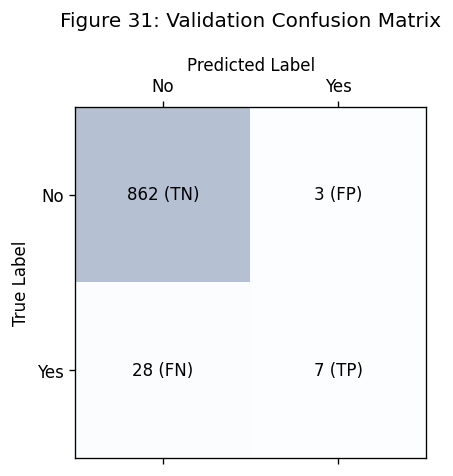

In [12]:
from sklearn.metrics import confusion_matrix

# this creates the matplotlib graph to make the confmat look nicer
def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):

    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(width_inch, height_inch))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.show()
    
    
# use the first classifier to predict the validation set    
predictions = lin_rs.best_estimator_.predict(X_val)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true=y_val, y_pred=predictions)

fig_num+=1
# use the pretty function to make it nicer
pretty_confusion_matrix(confmat, LE.classes_,
                        "Figure %d: Validation Confusion Matrix"%fig_num,
                        labeling=True,
                       )

**Error and Accuracy**$^1$

Gives general performance information regarding the number of all correct or false predictions comparative to the total number of predictions for both the positive and negative labels.

$$
\begin{align}
ERR &= \frac{FP+FN}{FP+FN+TP+TN} \\ \\
ACC &= 1-ERR
\end{align}
$$

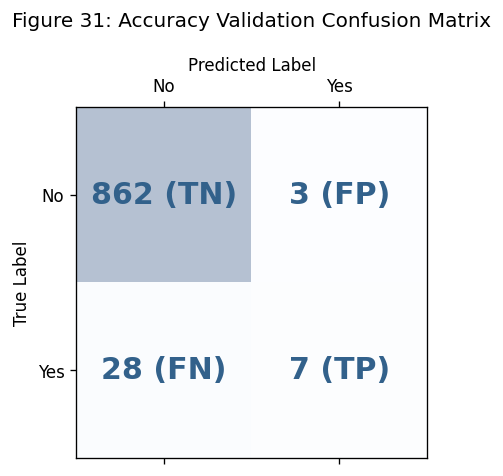

Accuracy (ACC): 0.966


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

ERR = (FP+FN)/(FP+FN+TP+TN)
ACC = 1-ERR

pretty_confusion_matrix(confmat, LE.classes_, 
                        "Figure %d: Accuracy Validation Confusion Matrix"%fig_num,
                        labeling=True, highlight_indexes=[FP_i,FN_i,TP_i,TN_i])

#print(color.BOLD+'Error (ERR): '+color.END +'%.3f' % ERR)
print(color.BOLD+'Accuracy (ACC): '+color.END +'%.3f' % ACC)
#print('Accuracy (ACC): %.3f' % accuracy_score(y_true=y_val, y_pred=predictions))

**Precision (PRE)**$^1$

- Precision gives information on how precise your model is by looking at how many positive predicted labels are actually positive. 
- Precision is a good measure to determine, when the costs of a False Positive is high.

$$
PRE = \frac{TP}{TP+FP}
$$

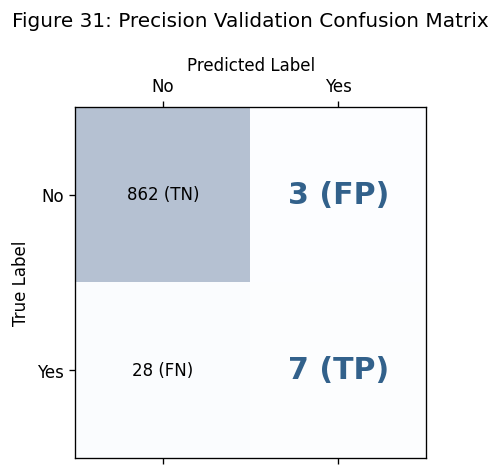

Precision (PRE): 0.700


In [14]:
PRE = TP/(TP+FP)

pretty_confusion_matrix(confmat, LE.classes_, 
                        "Figure %d: Precision Validation Confusion Matrix"%fig_num,
                        labeling=True, highlight_indexes=[FP_i,TP_i])

print(color.BOLD+'Precision (PRE): '+color.END +'%.3f' % PRE)
#print('Precision (PRE): %.3f' % precision_score(y_true=y_val, y_pred=predictions))

**Recall (or True Positive Rate)**$^1$

- Calculates how many of the actual positives our model correctly or incorrectly labelled. 

- This is useful when the fraction of correctly or misclassified samples in the positive class are of interest.

$$
REC = \frac{TP}{FN+TP}
$$

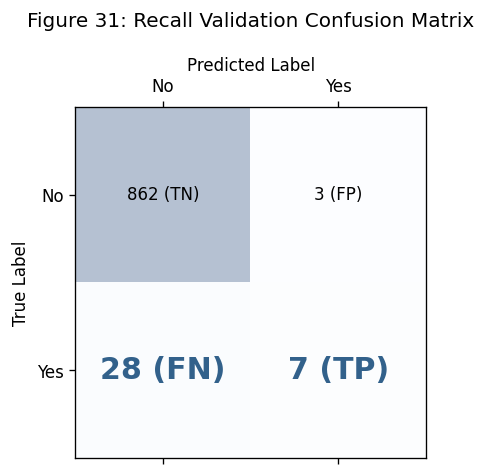

Recall (REC): 0.200


In [15]:
REC = TP/(FN+TP)

pretty_confusion_matrix(confmat, LE.classes_, 
                        "Figure %d: Recall Validation Confusion Matrix"%fig_num,
                        labeling=True, highlight_indexes=[FN_i,TP_i])

print(color.BOLD+'Recall (REC): '+color.END +'%.3f' % REC)
#print('Recall (REC): %.3f' % recall_score(y_true=y_val, y_pred=predictions))

**F1-score**$^1$

- F1-score is a combination of Recall and Precision. 
- It is typically used when there is an __uneven class distribution__ due to a large number of True Negatives that you are not as focused on. 

$$
F1 = 2\left(\frac{PRE \times REC}{PRE + REC}\right)
$$

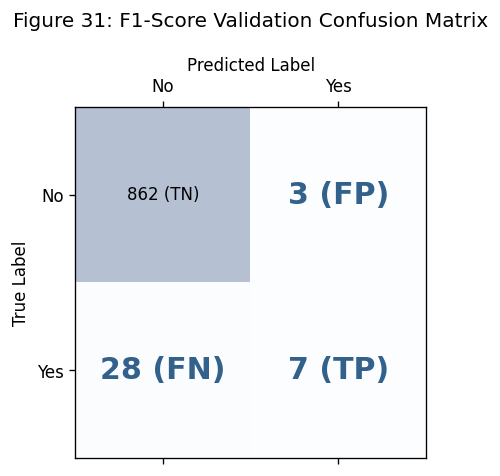

F1-Score (F1): 0.311


In [16]:
F1 = 2*((PRE*REC)/(PRE+REC))

pretty_confusion_matrix(confmat, LE.classes_, 
                        "Figure %d: F1-Score Validation Confusion Matrix"%fig_num,
                        labeling=True, highlight_indexes=[FN_i,TP_i, FP_i])

print(color.BOLD+'F1-Score (F1): '+color.END +'%.3f' % F1)
#print('F1-score (F1): %.3f' % f1_score(y_true=y_val, y_pred=predictions))

We can use a classification report, which gives more information such as the macro avg and weighted avg.

 **Macro Average**
 - Treats all classes equally as each metric is calculated independently and the average is taken.

**Weighted Average** 
- Each contribution to the average is weighted by the relative number of examples in a class available.

__Notes__

- The support is the number of occurrences of each class in y_true.
- Notice how the previous metrics were based on the `"yes"` class. This is because in binary classification problems, the default positive label is the target (class 1). You can change this if you are more interested in the other classes performance or the average metrics.

In [17]:
from sklearn.metrics import classification_report

pd.DataFrame(classification_report(y_val, 
                                   predictions, 
                                   labels=None, 
                                   target_names=LE.classes_, 
                                   sample_weight=None, 
                                   digits=2, 
                                   output_dict=True)).round(2)

,No,Yes,accuracy,macro avg,weighted avg
precision,0.97,0.70,0.97,0.83,0.96
recall,1.00,0.20,0.97,0.60,0.97
f1-score,0.98,0.31,0.97,0.65,0.96
support,865.00,35.00,0.97,900.00,900.00


__Notes__

- For further reading on different performance metrics see David M. W. Powers' technical report [Evaluation: From Precision,  Recall and F-Factor to ROC, Informedness, Markedness & Correlation](https://arxiv.org/ftp/arxiv/papers/2010/2010.16061.pdf)

## Potential Reasons for Poor Performance

__Training Error > Test Error__$^5$

- Training error rates will usually be lower than test error rates.
- The higher the ratio of parameters $p$ to number of samples $n$, the more we expect this overfitting to play a role.

__Notes__
- _"We may expect this classifier to perform worse if we use it to predict whether or not a new set of individuals will default. The reason is that we specifically adjust the parameters of our model to do well on the training data."_<sup>5</sup>
- _"For overfitting these data we don’t expect this to be a problem, since p = 2 and n = 10, 000."_

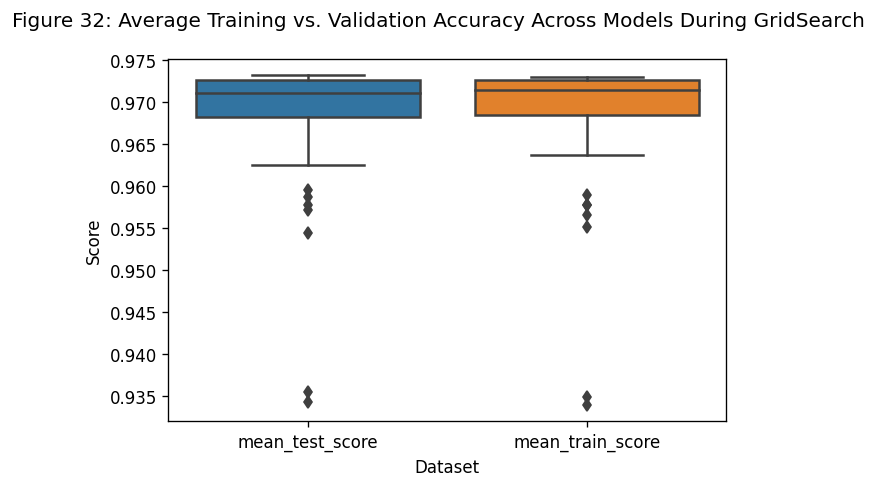

In [18]:
lin_rs_plt = lin_rs_df[['mean_test_score','mean_train_score']].melt(var_name='Dataset', value_name= 'Score')
sns.boxplot(data = lin_rs_plt, x = 'Dataset', y='Score')
fig_num+=1
plt.suptitle("Figure %d: Average Training vs. Validation Accuracy Across Models During GridSearch"%fig_num)
plt.show()

__Optimising for Accuracy__ 

During hyperparamter cross-validation we are choosing the model with the best __overall accuracy__. 

This gives us a model with the smallest possible total number of misclassified observations, irrespective of which class the errors come from$^5$. 

ML algorithms typically optimize a reward or cost function computed as a sum over the training examples, the decision rule is likely going to be biased toward the majority class$^9$.

__Notes__

- _"In other words, the algorithm implicitly learns a model that optimizes the predictions based on the most abundant class in the dataset, in order to minimize the cost or  maximize the reward during training."_<sup>9</sup>. 

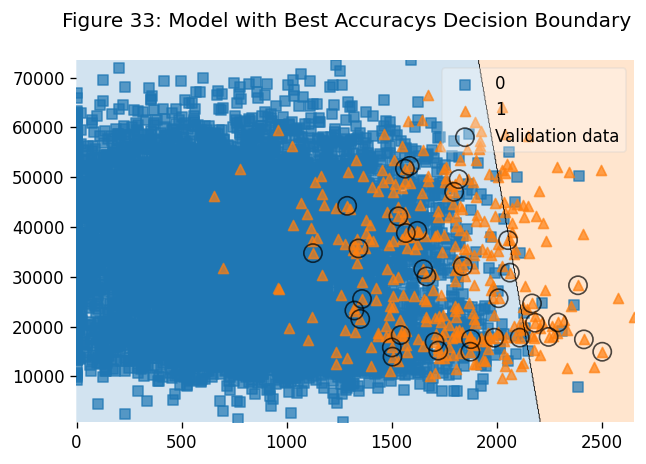

In [19]:
from mlxtend.plotting import plot_decision_regions
scatter_kwargs = {'edgecolor': None, 'alpha': 0.7}
contourf_kwargs = {'alpha': 0.2}
scatter_highlight_kwargs = {'s': 120, 'label': 'Validation data', 'alpha': 0.7}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_decision_regions(data_x.values, data_y, clf=lin_rs, 
                          legend=1, X_highlight=X_val[y_val==1],
                          contourf_kwargs=contourf_kwargs,
                          scatter_kwargs=scatter_kwargs,
                          scatter_highlight_kwargs=scatter_highlight_kwargs
                         )
    fig_num+=1
    plt.suptitle("Figure %d: Model with Best Accuracys Decision Boundary"%fig_num)

## Potential Solutions for Poor Performance

There are a number of methods available to address imbalances in a dataset, such as:
1. Stratify the k-fold,
2. Weighting the classes in the model during training, 
3. Changing the training metric, 
4. Resampling the data.

### Stratified k-fold

Some of the fold may not have the same amount of data in, so the validation error we get from models may be a poor estimate of performance.

In [20]:
KF = KFold(n_splits=5)
SKF = StratifiedKFold(n_splits=5)

fold_names = ["KFold", "StratifiedKFold"]
for i, K in enumerate([KF, SKF]):
    print(color.BOLD+color.UNDERLINE+fold_names[i]+color.END)
    for j, (train_i, test_i) in enumerate(K.split(X_train, y_train)):
        fold_no = pd.DataFrame(pd.Series(y_train[test_i]).value_counts(), columns=["Fold "+str(j)])
        if j == 0:
            fold_nos = fold_no
        else:
            fold_nos = pd.concat([fold_nos,fold_no], axis=1)
        
    display(fold_nos)

KFold


,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4
0,1565,1572,1577,1570,1560
1,55,48,43,50,60


StratifiedKFold


,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4
0,1568,1569,1569,1569,1569
1,52,51,51,51,51


### Weights

During model fitting we can assign a larger penalty to wrong predictions on the minority class.

The heuristic used for `class_weight="balanced"` in Scikit-Learn (0.23.1) is:

$$
\frac{n}{Nc \times \sum\limits^n_{i=1}I(y_i \in S)},
$$

where $n$ are the number of samples, $Nc$ the number of classes, $I$ is an indicator function, and $S$ contains the class elements.

In [21]:
lin_param_dist['svm_clf__class_weight'] = [None, "balanced"]

bal_lin_rs = hyper_search(linear_svm, lin_param_dist, X_train, y_train,
                          os.path.join(os.getcwd(), "Models", "def_bal_lin_rs.pkl"),
                          metric = ["accuracy", "f1","recall","precision"], 
                          refit=False, # we will refit manually later
                          cv = SKF, overwrite=False)

bal_lin_rs_df = pd.DataFrame(bal_lin_rs.cv_results_)
bal_lin_rs_df.sort_values("mean_test_accuracy", ascending=False)[["param_svm_clf__class_weight", 
                                                                  "param_svm_clf__C", 
                                                                  "mean_test_accuracy", 
                                                                  "std_test_accuracy"]].head()

,param_svm_clf__class_weight,param_svm_clf__C,mean_test_accuracy,std_test_accuracy
12,None,12.457135,0.972963,0.002512
19,None,20.185646,0.972963,0.002512
16,None,17.404635,0.972963,0.002512
0,None,5.620905,0.972963,0.002388
52,None,4.498096,0.972963,0.002388


In [22]:
from sklearn.base import clone

# we refit the best accuracy model on all the training data
# so lets do that for the best other metric models

def manual_refit(input_model, X, y, gs, metric, disp_df=[]):
    output_model = clone(input_model)
    
    gs_df = pd.DataFrame(gs.cv_results_).sort_values("mean_test_"+metric, ascending=False)
    
    if disp_df:
        display(gs_df[disp_df].head())
    
    params = gs_df["params"].iloc[0]
    output_model = output_model.set_params(**params)
    output_model = output_model.fit(X, y)
    
    return output_model

acc_model = manual_refit(linear_svm, X_train, y_train, bal_lin_rs, "accuracy")

C:\Users\delliot2\.conda\envs\mlp\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


__Extra__

So far in these notes we have been using a standard classifcation table fom Scikit-Learn, however we may wish instead to use one more suited to imballanced data.

__TODO__
- explain new metrics

__Notes__
- In our example case here just changing the weights alone doesn't do much (if anything). We'll see this in a figure later.

In [23]:
def imbalanced_report_df(y_val, y_pred, target_names):

    imb_str = classification_report_imbalanced(y_val, 
                                               y_pred,
                                               target_names=target_names)
    sl = re.split(' |\n|\n\n',imb_str)
    scores = []
    for string in sl:
        try: 
            scores.append(float(string))
        except:
            continue

    n=7
    scores = [scores[i * n:(i + 1) * n] for i in range((len(scores) + n - 1) // n )] 
    scores_df = pd.DataFrame(scores, 
                             index=[target_names + ['avg / total']], 
                             columns = ['precision','recall','specificity','f1-score','geo','iba','support']).T
    
    return scores_df

display(pd.DataFrame(classification_report(y_val, 
                                   acc_model.predict(X_val), 
                                   labels=None, 
                                   target_names=list(LE.classes_), 
                                   sample_weight=None, 
                                   digits=2, 
                                   output_dict=True)).round(2))

bal_lin_rs_rpt = imbalanced_report_df(y_val, acc_model.predict(X_val), target_names=list(LE.classes_))
display(bal_lin_rs_rpt)

,No,Yes,accuracy,macro avg,weighted avg
precision,0.97,0.73,0.97,0.85,0.96
recall,1.00,0.23,0.97,0.61,0.97
f1-score,0.98,0.35,0.97,0.67,0.96
support,865.00,35.00,0.97,900.00,900.00


,No,Yes,avg / total
precision,0.97,0.73,0.96
recall,1.00,0.23,0.97
specificity,0.23,1.00,0.26
f1-score,0.98,0.35,0.96
geo,0.48,0.48,0.48
iba,0.25,0.21,0.24
support,865.00,35.00,900.00


### Changing Training/Validation Metric

Changing the metric for what is defined as the _"best model"_ can help us prioritise models that make particular errors.

For example, a credit card company might particularly wish to avoid incorrectly classifying an individual who will default, whereas incorrectly classifying an individual who will not default, though still to be avoided, is less problematic. 

In this case, __recall__ would therefore be a useful metric to use.

__Notes__
- Now we see that `balanced` models are indeed better if we want a good average recall or f1

In [24]:
rec_model = manual_refit(linear_svm, X_train, y_train, bal_lin_rs, "recall", 
                         disp_df=["param_svm_clf__class_weight", 
                                  "param_svm_clf__C", 
                                  "mean_test_recall",
                                  "std_test_recall"])
rec_lin_rs_rpt = imbalanced_report_df(y_val, rec_model.predict(X_val), target_names=list(LE.classes_))

f1_model = manual_refit(linear_svm, X_train, y_train, bal_lin_rs, "f1", 
                         disp_df=["param_svm_clf__class_weight", 
                                  "param_svm_clf__C", 
                                  "mean_test_f1",
                                  "std_test_f1"])
f1_lin_rs_rpt = imbalanced_report_df(y_val, f1_model.predict(X_val), target_names=list(LE.classes_))

,param_svm_clf__class_weight,param_svm_clf__C,mean_test_recall,std_test_recall
9,balanced,0.031589,0.882730,0.021834
10,balanced,0.397242,0.878808,0.029134
37,balanced,2.889491,0.878808,0.029134
1,balanced,0.397409,0.878808,0.029134
14,balanced,0.216116,0.878808,0.029134


,param_svm_clf__class_weight,param_svm_clf__C,mean_test_f1,std_test_f1
32,balanced,61.146821,0.505370,0.035163
41,balanced,55.477953,0.481678,0.035227
23,balanced,76.945463,0.478551,0.054680
18,balanced,38.980718,0.450244,0.038279
36,balanced,124.327323,0.408983,0.033208


C:\Users\delliot2\.conda\envs\mlp\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


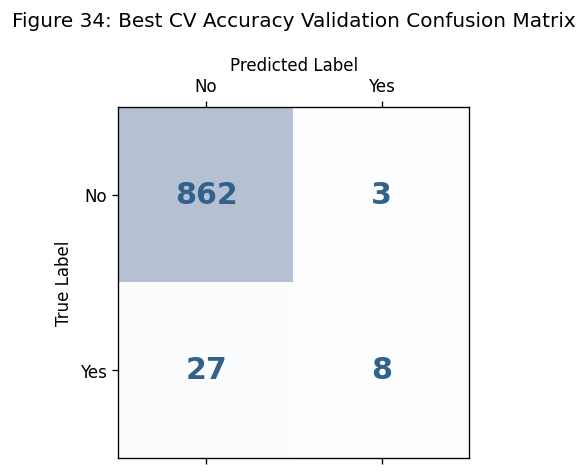

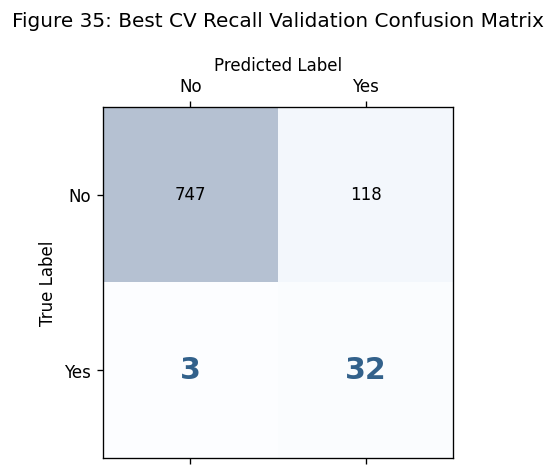

In [25]:
# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true=y_val, y_pred=acc_model.predict(X_val))
fig_num+=1
# use the pretty function to make it nicer
pretty_confusion_matrix(confmat, LE.classes_, 
                        "Figure %d: Best CV Accuracy Validation Confusion Matrix"%fig_num,
                        highlight_indexes=[FP_i,FN_i,TP_i,TN_i]
                       )

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true=y_val, y_pred=rec_model.predict(X_val))
fig_num+=1
# use the pretty function to make it nicer
pretty_confusion_matrix(confmat, LE.classes_, 
                        "Figure %d: Best CV Recall Validation Confusion Matrix"%fig_num,
                        highlight_indexes=[FN_i,TP_i]
                       )

__Extra__

This is just some additional visualisations.

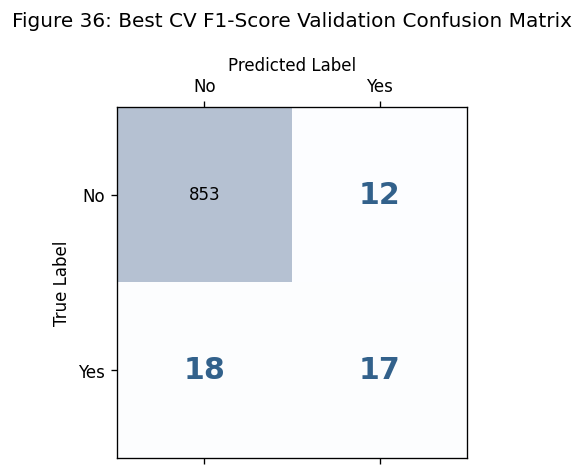

In [26]:
# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true=y_val, y_pred=f1_model.predict(X_val))
fig_num+=1
# use the pretty function to make it nicer
pretty_confusion_matrix(confmat, LE.classes_ , 
                        "Figure %d: Best CV F1-Score Validation Confusion Matrix"%fig_num,
                        highlight_indexes=[FN_i,TP_i, FP_i]
                       )

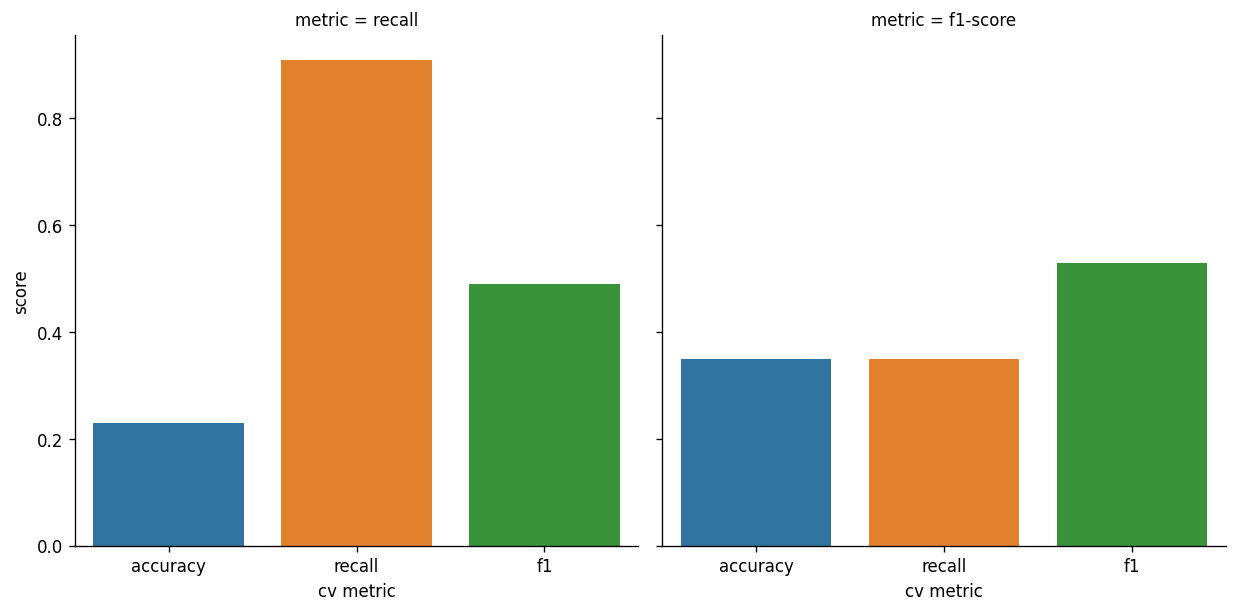

In [27]:
def imb_report_prep(df, new_col_name, new_col_val):

    df_ = df.T.stack()
    df_ = df_.reset_index()
    df_.columns = ["class", "metric", "score"]
    df_[new_col_name] = new_col_val
    return df_

bal_lin_rs_rpt_ = imb_report_prep(bal_lin_rs_rpt, 'cv metric', "accuracy")
rec_lin_rs_rpt_ = imb_report_prep(rec_lin_rs_rpt, 'cv metric', "recall")
f1_lin_rs_rpt_ = imb_report_prep(f1_lin_rs_rpt, 'cv metric', "f1")
lin_rs_rpt = pd.concat([bal_lin_rs_rpt_, rec_lin_rs_rpt_, f1_lin_rs_rpt_])

lin_rs_rpt_plt = lin_rs_rpt[lin_rs_rpt['class']=='Yes']
lin_rs_rpt_plt = lin_rs_rpt_plt[lin_rs_rpt_plt["metric"].isin(["recall", "f1-score"])]

sns.catplot(data = lin_rs_rpt_plt,
            x = "cv metric", y = 'score', 
            col='metric', col_wrap=4, kind="bar")

plt.show()

Providing your comfortable using metrics instead of relying on a `confusion_matrix`, you can use more of your training data by just using the multiple metrics in the `CvGridSearch`. 

From here on in, I will get rid of my separate training and validation sets and I will just use `"recall"` as our metric of interest.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data_x.values, data_y, test_size = 0.1, random_state=42)

wt_lin_rs = hyper_search(linear_svm, lin_param_dist, X_train, y_train,
                         os.path.join(os.getcwd(), "Models", "def_wt_lin_rs.pkl"),
                         metric = ["f1","recall","precision"], refit='recall', 
                         cv = SKF, overwrite=False)

### Resampling

We can change the distribution of the classes in our training data.

#### Under-Sampling

A fast way to balance the data is just to randomly select a subset of the data for each class so they have the number of datapoints found in the smallest class.

__Notes__

- `RandomUnderSampler` is part of the Imblearn package, which allows for a lot of techniques for working with imballanced data.
- There is a `resample` method in `scikit-learn` but Imblearn is a bit smoother to work with.

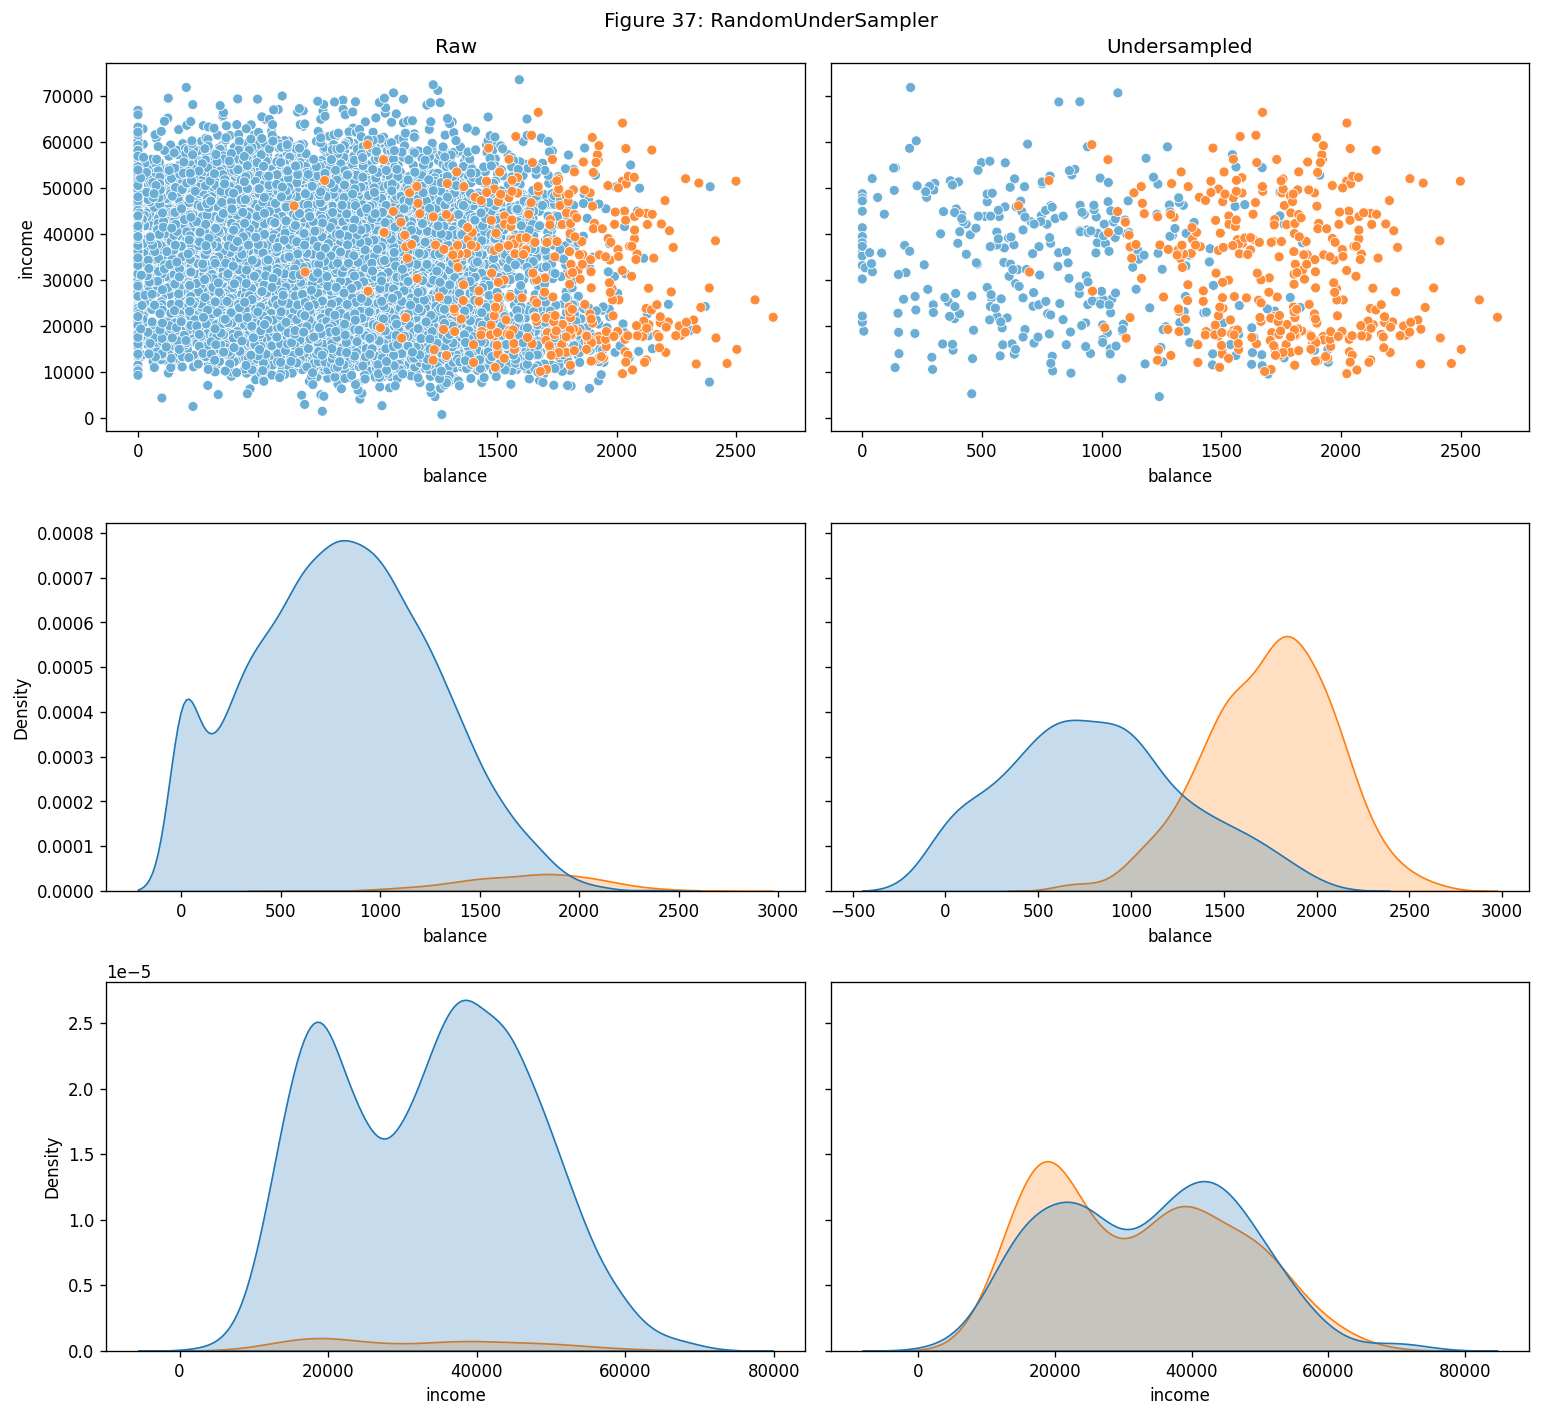

In [29]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

def plot_manual_pairplot(data_x, data_y, ax, title=None, col=0):

    data_plot = data_x.copy()
    data_plot['class'] = np.vectorize({0:'No', 1:'Yes'}.get)(data_y)
    
    if title:
        ax[0, col].set_title(title)
    sns.scatterplot(data = data_plot[data_plot['class']=="No"], x = "balance", y="income", 
                    hue="class", palette='Blues',ax=ax[0, col], legend=False)
    sns.scatterplot(data = data_plot[data_plot['class']=="Yes"], x = "balance", y="income",
                    hue="class", palette='Oranges',ax=ax[0, col], legend=False)
    
    sns.kdeplot("balance", data=data_plot, hue="class",ax=ax[1, col], fill=True, legend=False)
    sns.kdeplot("income", data=data_plot, hue="class",ax=ax[2, col], fill=True, legend=False)

def imblearn_sample(sampler, data_x, data_y, titles, main_title, counter=False):
    fig, axes = plt.subplots(3,2, figsize=(width_inch*2, height_inch*3), sharey='row')
    plot_manual_pairplot(data_x, data_y, axes, titles[0])

    data_x_downsampled, data_y_downsampled = sampler.fit_resample(data_x,
                                                                 data_y)
    
    if counter:
        print(color.UNDERLINE + 'Before Resample' + color.END)
        print(Counter(data_y))
        print(color.UNDERLINE + 'After Resample' + color.END)
        print(Counter(data_y_downsampled))

    plot_manual_pairplot(data_x_downsampled, data_y_downsampled, axes, titles[1], 1)
    plt.suptitle(main_title)
    plt.tight_layout()
    plt.show()

fig_num+=1
undersampler = RandomUnderSampler(random_state=123)
imblearn_sample(undersampler, data_x, data_y, ["Raw", "Undersampled"],
                'Figure %d: RandomUnderSampler'%fig_num)

In [30]:
from imblearn.pipeline import Pipeline as ImPipeline

if 'svm_clf__class_weight' in lin_param_dist.keys():
    del lin_param_dist['svm_clf__class_weight']

linear_svm = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", undersampler),
    ("svm_clf", LinearSVC(random_state=42))
    ])

us_lin_rs = hyper_search(linear_svm, lin_param_dist, X_train, y_train,
                         os.path.join(os.getcwd(), "Models", "def_us_lin_rs.pkl"),
                         metric = ["f1","recall","precision"], refit='recall', cv = SKF, 
                         overwrite=False)

__Note__
- Make sure your sampler is __in the pipeline__, otherwise you'll be training and testing your data on a smaller/larger sample than normal and get unrepresentative results!
    - this is an easy mistake to make... I did it when setting this up :')

#### Oversampling
Data can be oversampled easily by randomly sampling from minority classes with replacement to duplicate original samples. 

__Notes__
- make sure to oversample after splitting the training and validation sets or you may "bleed" information into the validation sets of the model when trying to test a model<sup>7</sup>... In-other-words, make sure it is in a pipeline!

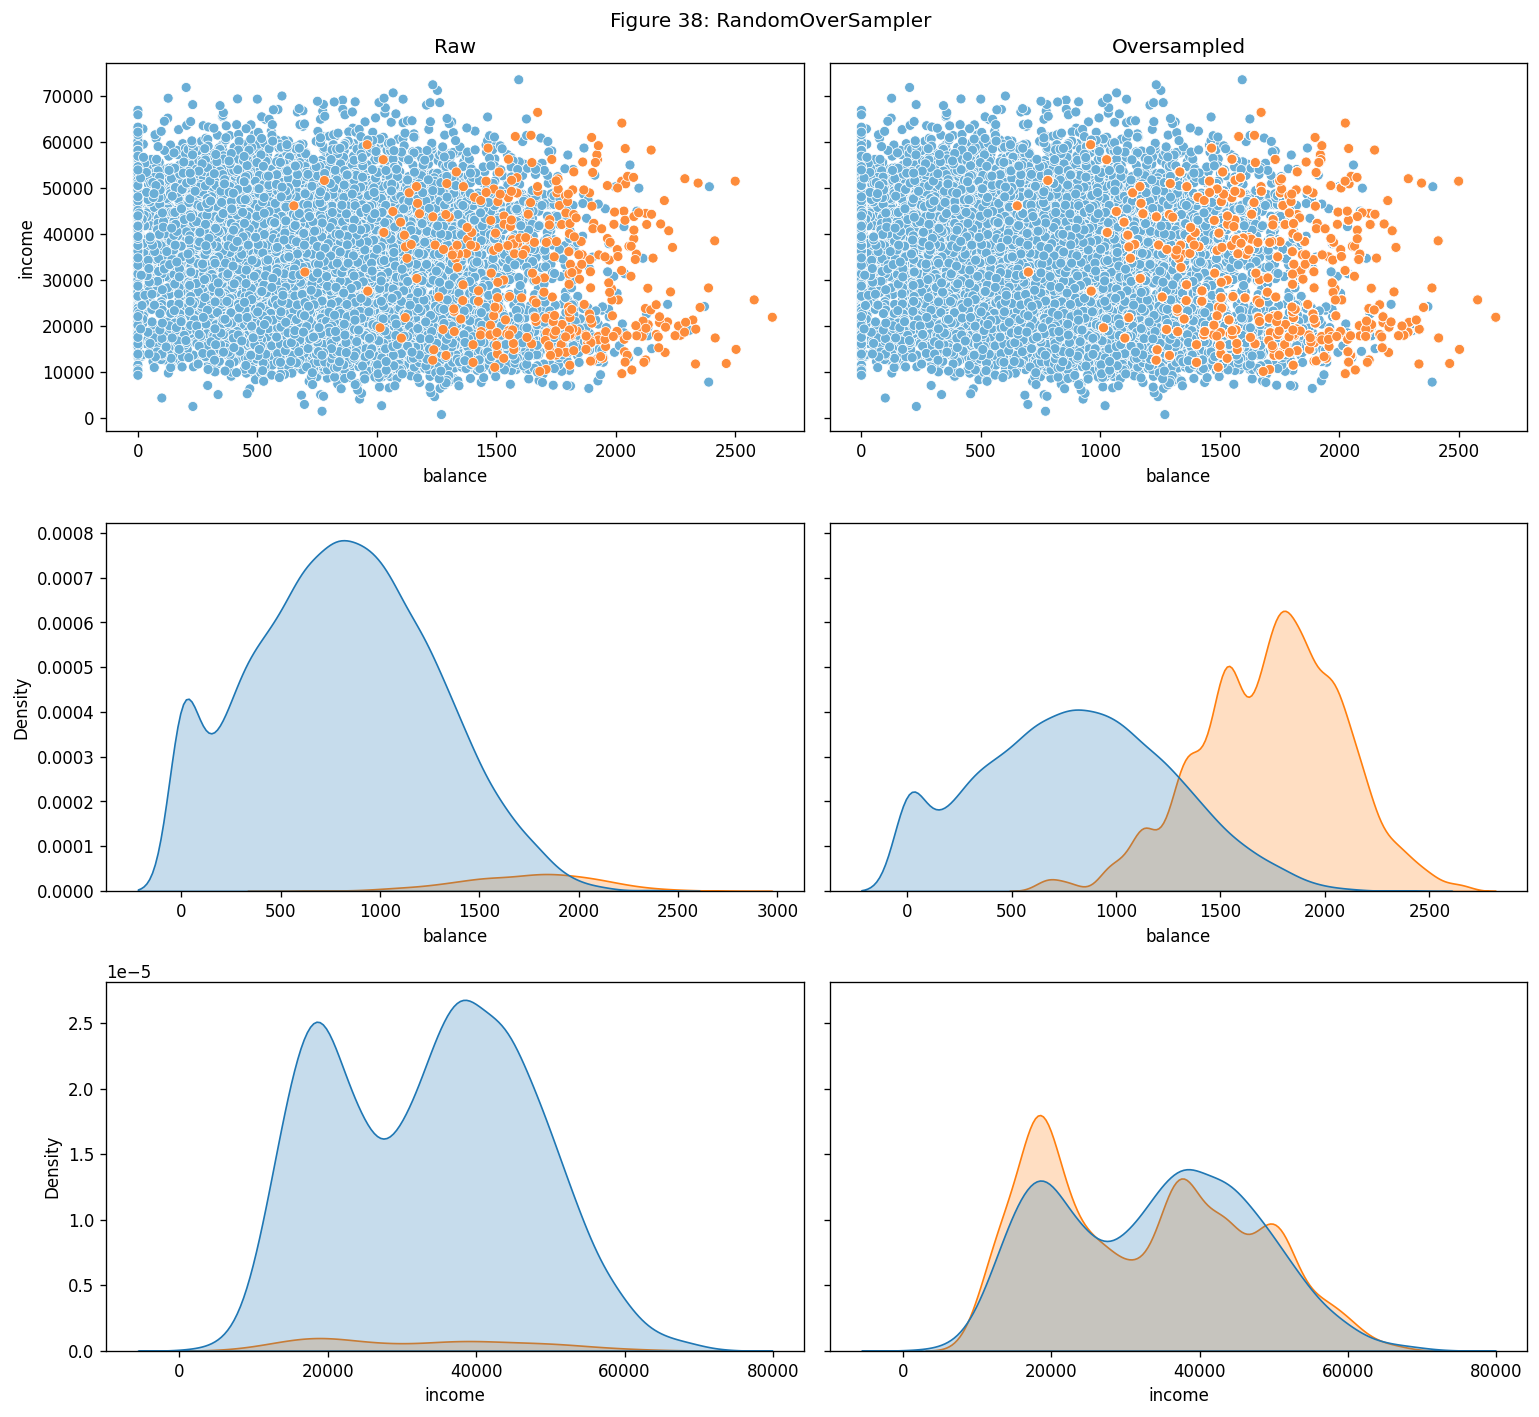

In [31]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(random_state=123)
fig_num+=1
imblearn_sample(oversampler, data_x, data_y, ["Raw", "Oversampled"],
                'Figure %d: RandomOverSampler'%fig_num
               )

In [32]:
linear_svm = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", oversampler),
    ("svm_clf", LinearSVC(random_state=42))
    ])

os_lin_rs = hyper_search(linear_svm, lin_param_dist, X_train, y_train,
                          os.path.join(os.getcwd(), "Models", "def_os_lin_rs.pkl"),
                          metric = ["f1","recall","precision"], refit='recall', overwrite=False)

We can see if a RBF improves things although, if you plan on running this yourself (`overwrite=True`), this is computationally expensive.

In [33]:
# specify parameters and distributions to sample from
rbf_param_dist = lin_param_dist.copy()
gamma_list = []
pwr = -15
for i in range(10):
    gamma_list.append(2**pwr)
    pwr+=2
rbf_param_dist['svm_clf__gamma'] = loguniform(gamma_list[0], gamma_list[-1])

# -----------
# Undersample
# -----------
rbf_svm = ImPipeline([
        ("scaler", StandardScaler()),
        ("sampler", undersampler),
        ("svm_clf", SVC(random_state=42))])

us_rbf_rs = hyper_search(rbf_svm, rbf_param_dist, X_train, y_train,
                         os.path.join(os.getcwd(), "Models", "def_us_rbf_rs.pkl"),
                         metric = ["f1","recall","precision"], 
                         refit='recall', cv = SKF, overwrite=False)
# ----------
# Oversample
# ----------
#rbf_svm = ImPipeline([
#        ("scaler", StandardScaler()),
#        ("sampler", oversampler),
#        ("svm_clf", SVC(random_state=42))])
#os_rbf_rs = hyper_search(rbf_svm, rbf_param_dist, X_train, y_train,
#                          os.path.join(os.getcwd(), "Models", "def_os_rbf_rs.pkl"),
#                          metric = ["f1","recall","precision"], refit='f1', cv = SKF, overwrite=False)

# -------
# Weights
# -------
rbf_svm = ImPipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(random_state=42))])
rbf_param_dist['svm_clf__class_weight'] = [None, "balanced"]
#wt_rbf_rs = hyper_search(rbf_svm, rbf_param_dist, X_train, y_train,
#                          os.path.join(os.getcwd(), "Models", "def_wt_rbf_rs.pkl"),
#                          metric = ["f1","recall","precision"], refit='f1', cv = SKF, overwrite=False)

### Extra

#### NearMiss

A number of undersampling methods use heuristics based on k-nearest neighbors (KNN) classification<sup>8</sup>. KNN finds a number of samples that are the most similar to a data point we want to classify, based on a given distance metric, with its assigned class label depending on a majority vote by the nearest neighbours<sup>9</sup> (we'll come back to this later). NearMiss uses this by selecting samples in the class to be under-sampled where the average distance to the closest or farthest samples of the minority class is smallest<sup>10</sup>. 

#### NeighbourhoodCleaningRule

Undersampling techniques also include data cleaning rules, where the number of samples in classes are not specified, but data is edited based on methods such as removing data dissimilar to their neighbourhood<sup>11</sup> or by removing one or both samples in different classes when they are nearest neighbors of each other<sup>12</sup>.

#### ADASYN and SMOTE

Instead of just randomly oversampling there are also available approaches that generate new samples through the use of interpolation, such as SMOTE and ADASYN. However these methods can generate noisy samples so cleaning rule can be applied after oversampling<sup>13</sup>.

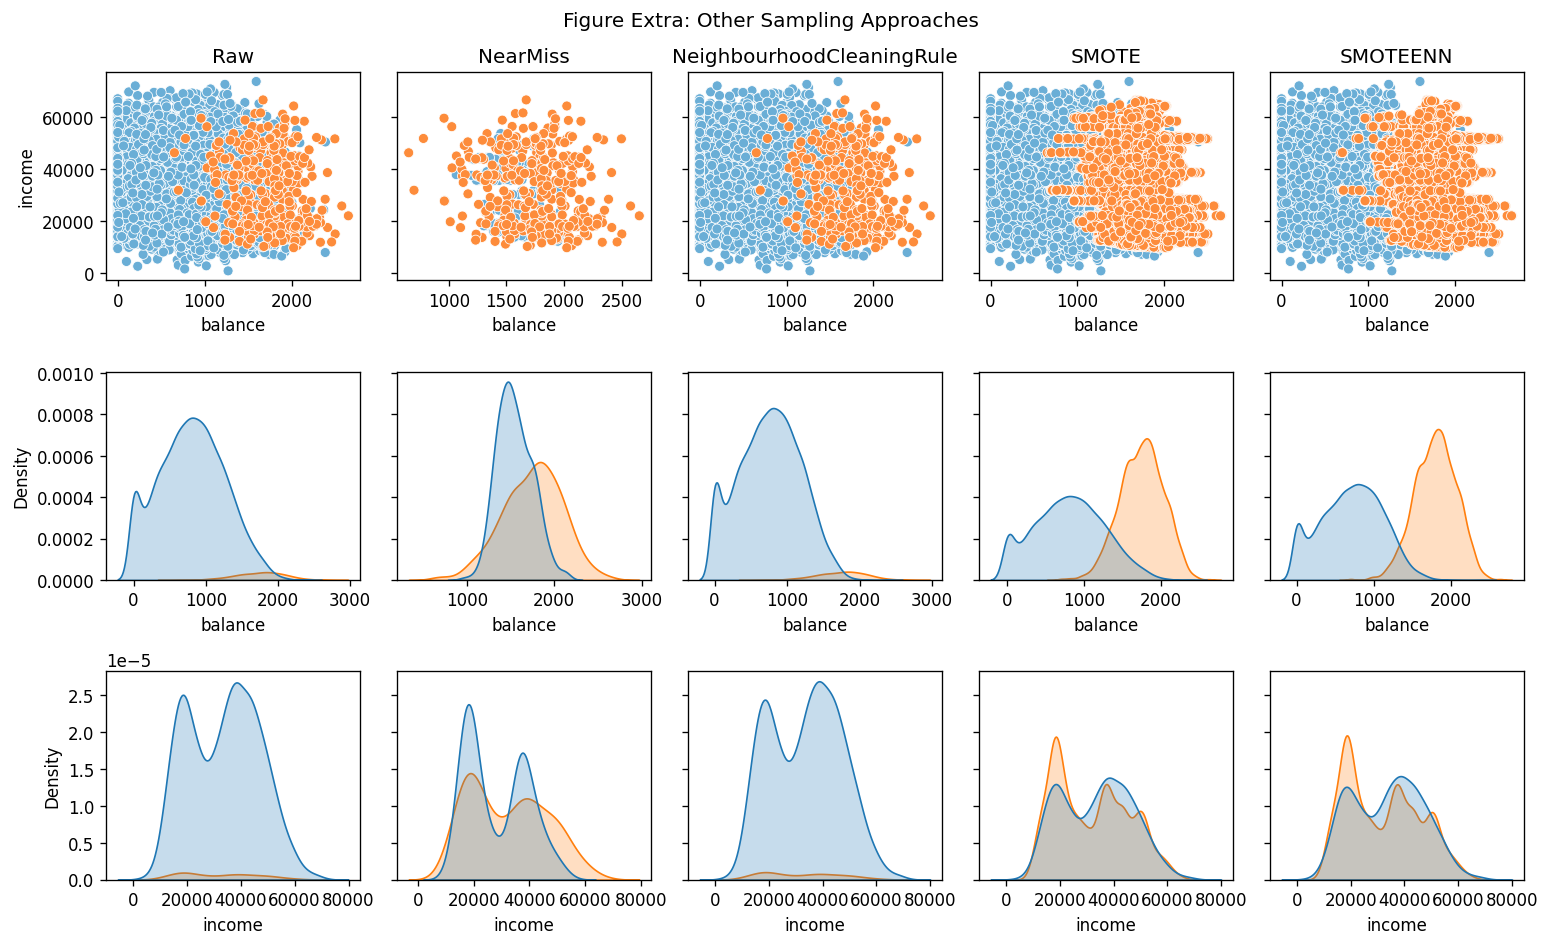

In [34]:
from imblearn.under_sampling import NearMiss, NeighbourhoodCleaningRule
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

fig, axes = plt.subplots(3,5, figsize=(width_inch*2, height_inch*2), sharey='row')
plot_manual_pairplot(data_x, data_y, axes, "Raw")

titles = ["NearMiss", "NeighbourhoodCleaningRule", "SMOTE", "SMOTEENN"]
for i, sampler in enumerate([NearMiss(), 
                             NeighbourhoodCleaningRule(),
                             SMOTE(random_state=42),
                             SMOTEENN(random_state=42)
                            ]):

    data_x_downsampled, data_y_downsampled = sampler.fit_resample(data_x,
                                                                  data_y)

    plot_manual_pairplot(data_x_downsampled, data_y_downsampled, axes, titles[i], i+1)
plt.suptitle('Figure Extra: Other Sampling Approaches')
plt.tight_layout()
plt.show()

## Best Approach?

There is no one best approach, its typically dependent on the data and the aims for the model.

Below are examples of cross-validation scores for the best models (according to recall) for the different approaches.

__Notes__
- If over- and under-sampling are not much different (which in a lot of cases they won't be) you would typically favor undersampling for the savings you get in computational cost.

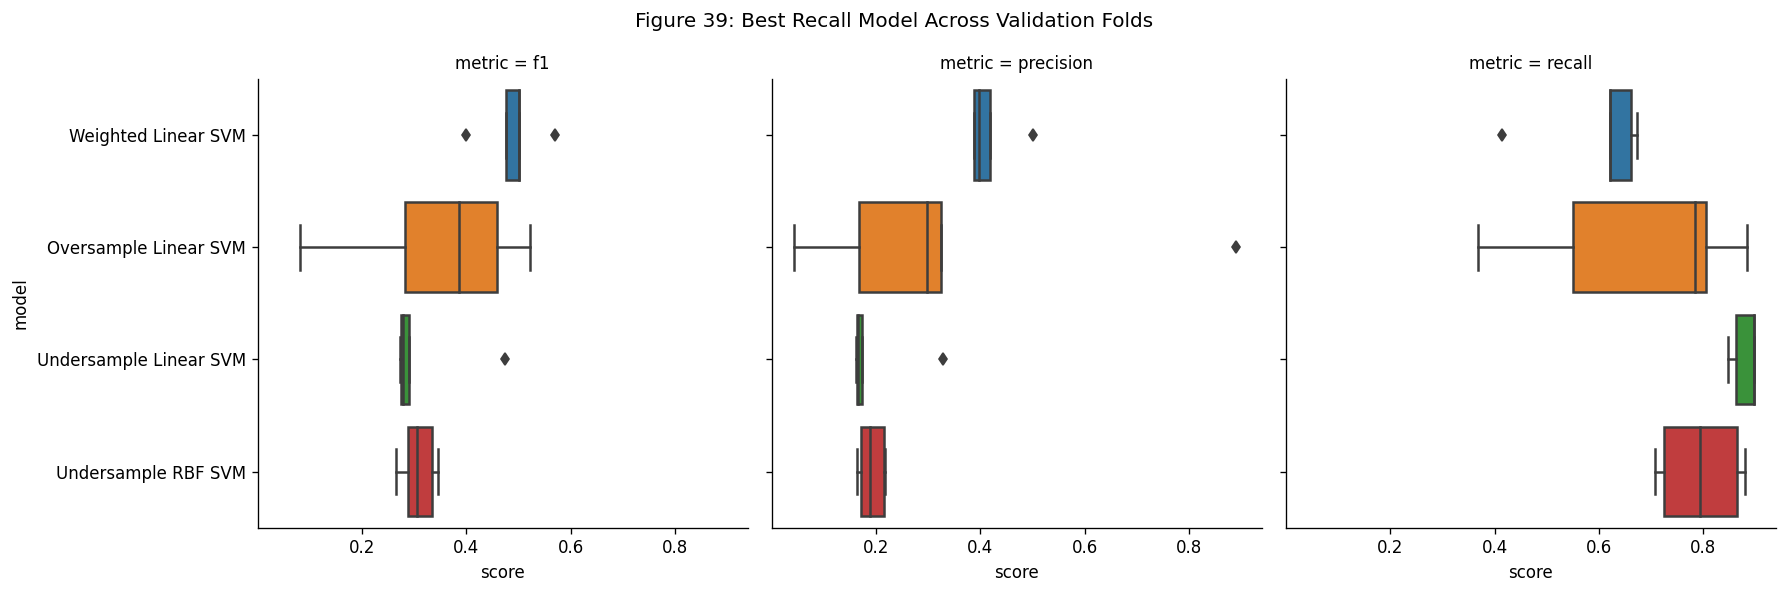

In [35]:
def imb_cv_prep(input_pd, model_name):
    metrics = ["f1", "precision", "recall"]
    for i, metric in enumerate(metrics):
        
        if isinstance(input_pd, pd.DataFrame):
            df_ = input_pd[["split0_test_"+metric, "split1_test_"+metric,
                                       "split2_test_"+metric, "split3_test_"+metric, 
                                       "split4_test_"+metric]].stack().reset_index()

            df_['fold'] = list(range(5))*(df_["level_0"].iloc[-1] +1)
            df_.columns = ["cv_iter", "metric", "score", "fold"]
            
        else:
        
            df_ = pd.DataFrame(input_pd[["split0_test_"+metric, "split1_test_"+metric,
                                       "split2_test_"+metric, "split3_test_"+metric, 
                                       "split4_test_"+metric]]).reset_index().reset_index()

            df_.columns = ["fold", "metric", "score"]
        df_['metric'] = df_.metric.str.replace('split0_test_','')
        df_['metric'] = df_.metric.str.replace('split1_test_','')
        df_['metric'] = df_.metric.str.replace('split2_test_','')
        df_['metric'] = df_.metric.str.replace('split3_test_','')
        df_['metric'] = df_.metric.str.replace('split4_test_','')
        
        if i == 0:
            df = df_
        else:
            df = pd.concat([df,df_])
        
    df['model'] = model_name
    
    return df

svm_scores_dict = {
    "Weighted Linear SVM": pd.DataFrame(wt_lin_rs.cv_results_).sort_values("rank_test_f1").iloc[0],
    "Oversample Linear SVM": pd.DataFrame(os_lin_rs.cv_results_).sort_values("rank_test_f1").iloc[0],
    "Undersample Linear SVM": pd.DataFrame(us_lin_rs.cv_results_).sort_values("rank_test_f1").iloc[0],
    "Undersample RBF SVM": pd.DataFrame(us_rbf_rs.cv_results_).sort_values("rank_test_f1").iloc[0]
}

for i, model_name in enumerate(svm_scores_dict):
    svm_score_df = imb_cv_prep(svm_scores_dict[model_name], model_name)
    if i ==0:
        svm_scores_df = svm_score_df
    else:
        svm_scores_df = pd.concat([svm_scores_df, svm_score_df])
        
       
sns.catplot(data = svm_scores_df, x = "score", y = 'model', 
            col='metric', col_wrap=3, kind="box",
            legend=False)

fig_num+=1
plt.suptitle("Figure %d: Best Recall Model Across Validation Folds"%fig_num)
plt.tight_layout() 

plt.show()

Using the figure above, for the client who wants the model to prioritise avoiding incorrectly classifying an individual who will default, we would probably choose the undersampled linear SVM.

As we can see on the test set, we get similar scores as we did on the validation.

__Notes__
- _"The distinction between the training set, validation set, and test set is fundamentally important to applying machine learning methods in practice. Any choices made based on the test set accuracy “leak” information from the test set into the model. Therefore, it is important to keep a separate test set, which is only used for the final evaluation. It is good practice to do all exploratory analysis and model selection using the combination of a training and a validation set, and reserve the test set for a final evaluation—this is even true for exploratory visualization. Strictly speaking, evaluating more than one model on the test set and choosing the better of the two will result in an overly optimistic estimate of how accurate the model is."_<sup>16</sup>

,No,Yes,avg / total
precision,0.99,0.25,0.96
recall,0.89,0.88,0.89
specificity,0.88,0.89,0.88
f1-score,0.94,0.39,0.91
geo,0.88,0.88,0.88
iba,0.78,0.78,0.78
support,958.00,42.00,1000.00


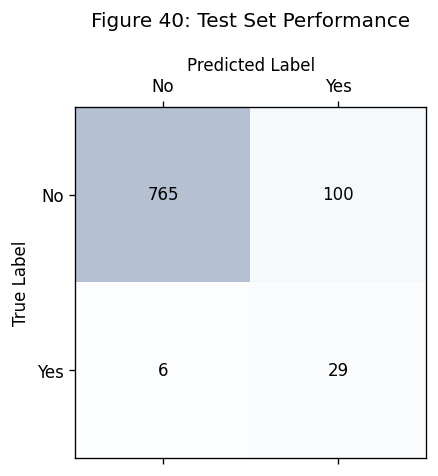

In [36]:
test_rpt = imbalanced_report_df(y_test, us_lin_rs.best_estimator_.predict(X_test), target_names=list(LE.classes_))
display(test_rpt)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true=y_val, y_pred=us_lin_rs.best_estimator_.predict(X_val))
fig_num+=1
# use the pretty function to make it nicer
pretty_confusion_matrix(confmat, LE.classes_, "Figure %d: Test Set Performance"%fig_num)

## Extra: Improving the model using more features

Would adding in if someone is a student improve the model?

__Note__
- As noted above, you wouldnt normally do any more changes to your model after looking at the test set... but I did that for the lecture purposes!

In [37]:
df = pd.read_csv("../Data/Default.csv", index_col=0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.62507
2,No,Yes,817.180407,12106.13470
3,No,No,1073.549164,31767.13895
4,No,No,529.250605,35704.49394
5,No,No,785.655883,38463.49588


__Note__

- We want to put our `OneHotEncoder` into the pipeline but not do it for continous data

In [38]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

data_x = df.drop(['default'], axis=1)

categorical_features = ['student']
numeric_features = ['balance', 'income']

X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(data_x, data_y, test_size = 0.1, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

linear_svm = ImPipeline([
    ("preprocessor", preprocessor),
    ("sampler", undersampler),
    ("svm_clf", LinearSVC(random_state=42))
    ])

us_stu_lin_rs = hyper_search(linear_svm, lin_param_dist, X_cat_train, y_cat_train,
                         os.path.join(os.getcwd(), "Models", "def_stud_us_lin_rs.pkl"),
                         metric = ["f1","recall","precision"], refit='recall', cv = SKF, 
                         overwrite=False)


rbf_svm = ImPipeline([
        ("preprocessor", preprocessor),
        ("sampler", undersampler),
        ("svm_clf", SVC(random_state=42))])

us_stu_rbf_rs = hyper_search(rbf_svm, rbf_param_dist, X_cat_train, y_cat_train,
                             os.path.join(os.getcwd(), "Models", "def_stud_us_rbf_rs.pkl"),
                             metric = ["f1","recall","precision"], 
                             refit='recall', cv = SKF, overwrite=False)

So in this case it does not seem to improve the metric of most interest (recall), although did improve precision at the expense of recall.

score                    
metric                            f1 precision    recall
model                                                   
Undersample Linear SVM      0.318034  0.198239  0.879836
Undersample New Linear SVM  0.353487  0.261527  0.801110
Undersample New RBF SVM     0.306990  0.189444  0.824605
Undersample RBF SVM         0.307376  0.191444  0.793571

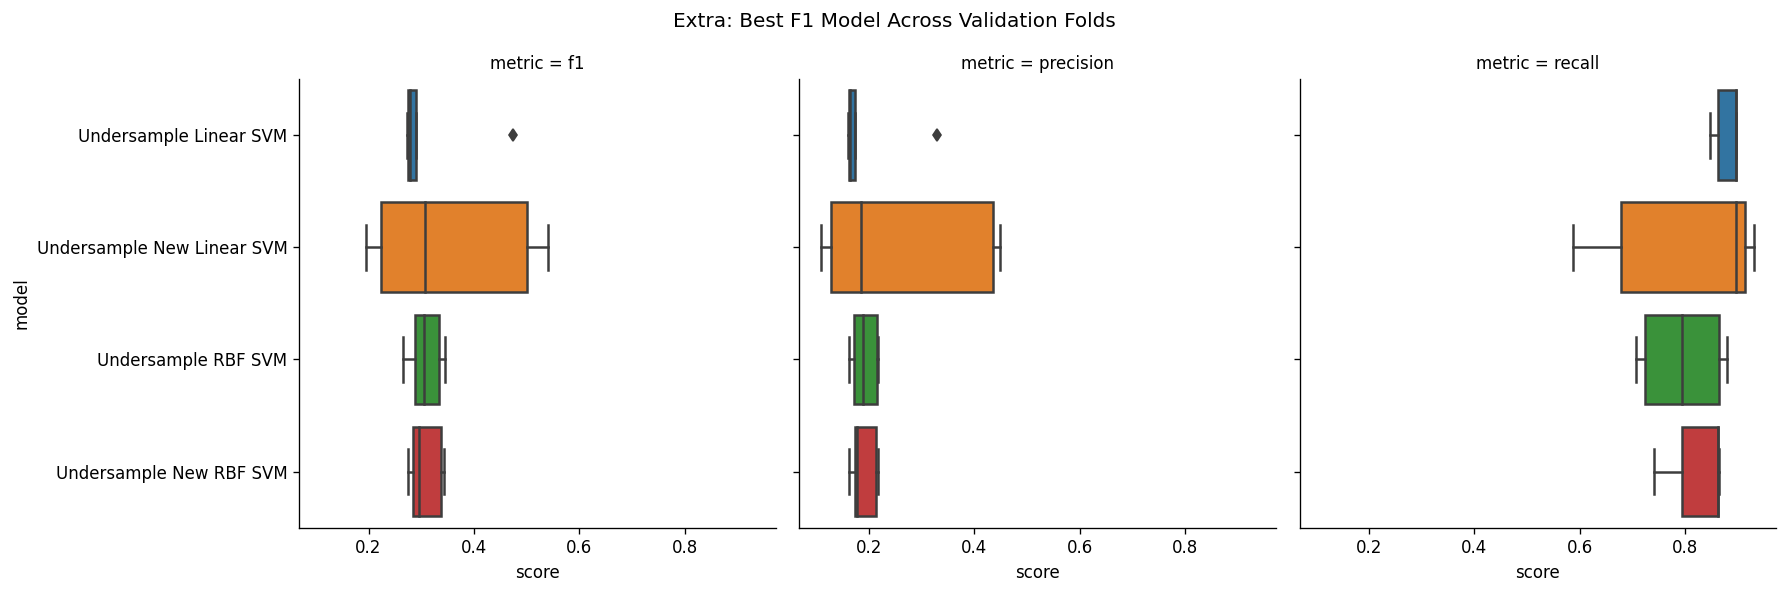

In [39]:
svm_scores_dict = {
    "Undersample Linear SVM": pd.DataFrame(us_lin_rs.cv_results_).sort_values("rank_test_f1").iloc[0],
    "Undersample New Linear SVM": pd.DataFrame(us_stu_lin_rs.cv_results_).sort_values("rank_test_f1").iloc[0],
    "Undersample RBF SVM": pd.DataFrame(us_rbf_rs.cv_results_).sort_values("rank_test_f1").iloc[0],
    "Undersample New RBF SVM": pd.DataFrame(us_stu_rbf_rs.cv_results_).sort_values("rank_test_f1").iloc[0]
}

for i, model_name in enumerate(svm_scores_dict):
    svm_score_df = imb_cv_prep(svm_scores_dict[model_name], model_name)
    if i ==0:
        svm_scores_df = svm_score_df
    else:
        svm_scores_df = pd.concat([svm_scores_df, svm_score_df])
        
svm_scores_df['score'] = svm_scores_df['score'].astype(float)
display(svm_scores_df.drop('fold', axis=1).groupby(['model', 'metric']).mean().unstack('metric'))
       
sns.catplot(data = svm_scores_df, x = "score", y = 'model', 
            col='metric', col_wrap=3, kind="box",
            legend=False)

plt.suptitle("Extra: Best F1 Model Across Validation Folds")
plt.tight_layout() 

plt.show()

__Fairness__

Imagine we used the model in practice, and those deemed more likely to default were given more unfavourable terms due to them being seeming more risky according to the algorithm?

- Is it fair that ~1/8 people might be deemed risky, getting higher rates, and then not defaulting on the loan simply because of the algorithmic score given to them?
- Do we think income is a fair predictor for us to use, may it be related to gender? Are we now giving out less loans to women because they typically earn less?
- As this data comes from people we already gave loans to, do we know if the data is bias in any way (e.g. did we give more loans out to a particular group)?

Imagine adding their student status had improved our model. Would it be fair to judge their chances of defaulting based on their student status rather than their actual financial information?

- You could argue yes as students tend to have more "risky" financial behaviour and university is expensive.
- What about the responcible student who knows they can afford to pay it back?
    
Maybe we need to know more about the people applying for the loan, but what variables do we use?
    
- Postcode
    - Maybe you think people who live in wealthy areas are more likely to pay back the loan? 
    - Doesn't this make it worse for people financially responcible people who live in poor areas? 
    - Might this unfortunately be related to someones race/ethnicity?
- Criminal History
    - Maybe criminals are less likely to pay back loans? 
    - Is our criminal system unbias?
       
This is a difficult but important aspect of ML and I leave it here to make you think about the possibilities. We'll be exploring this more in the last week.

__Notes__

- for more information on formal model comparisions see https://arxiv.org/pdf/1811.12808.pdf

# 7. Multi-Class <a id='multi'></a>

Some models (e.g. tree-based classifiers) are inherently multiclass, whereas other machine learning algorithms are able to be extended to multi-class classification using techniques such as the One-versus-Rest or One-versus-One methods<sup>3</sup>.

In [40]:
iris = load_iris(as_frame=True)  # data stored in a `sklearn.utils.Bunch`
iris_df = iris['data']           # get features DataFrame
target = iris['target']          # get target Series
# get the labels of flowers capitalised for visualisation
target_names = list(map(lambda s: s.capitalize(), iris['target_names']))

### One-verses-all (or One-vs-the-rest) 

The _One-verses-all_ approach is were you train a classifier for each class and select the class from the classifier that outputs the highest score$^3$. 

In other terms, if we fit $K$ SVMs, we assign a test observation, $x^*$, to the class for which $\beta_{0k} + \beta_{1k}x^*_1, ...,\beta_{pk}x^*_p$ is largest (the most confident)<sup>5</sup>. 

__Advantage:__ As each class is fitted against all other classes for each classifier, it is relatively interpretable$^{14}$.

__Disadvantages:__ Can result in ambiguious decision regions (e.g. could be class 1 or class 2), and classifiers could suffer from issues of class imballance$^4$.

__Notes__

- Alike to most plots in these lectures/notes, for ease of visualisation we'll only use two features.
- Although now inbuilt into `sklearn.svm.SVC`, you could also put the SVC inside `sklearn.multiclass.OneVsRestClassifier`

In [41]:
features = ["petal length (cm)", "petal width (cm)"]

ovr_rbf = SVC(kernel='rbf', 
              decision_function_shape = 'ovr', 
              random_state=42)

ovr_pipe = Pipeline([
    ('scl', StandardScaler()),
    ('svm_clf', ovr_rbf)])

ovr_rbf_rs = hyper_search(ovr_pipe, rbf_param_dist, iris_df[features].values, 
                          target.values, os.path.join(os.getcwd(), "Models", "iris_ovr_rbf_rs.pkl"),
                          cv = KFold(n_splits=3, shuffle=True, random_state=42), overwrite=False)

display(pd.DataFrame(ovr_rbf_rs.cv_results_).sort_values("rank_test_score")[["param_svm_clf__class_weight", 
                                                                             "param_svm_clf__C", 
                                                                             "param_svm_clf__gamma", 
                                                                             "mean_test_score", 
                                                                             "std_test_score"]].head())

,param_svm_clf__class_weight,param_svm_clf__C,param_svm_clf__gamma,mean_test_score,std_test_score
23,balanced,42.715424,0.001768,0.966667,0.018856
50,balanced,11.649174,0.002483,0.966667,0.018856
25,None,106.523159,0.001016,0.966667,0.018856
51,balanced,2.137057,0.017867,0.966667,0.018856
6,balanced,0.397242,0.062924,0.966667,0.018856


### OneVsOne

Another strategy is to use a _OneVsOne_ approach. 

This trains $N \times (N-1) / 2$ classifiers by comparing each class against each other. 

When a prediction is made, the class that is selected the most is chosen (_Majority Vote_)$^3$. 

__Advantage:__ It is useful where algorithms do not scale well with data size (such as SVM), because each training and prediction is only needed to be run on a small subset of the data for each classifer$^{3,14}$.

__Disadvantages:__ Can still result in ambiguious decision regions and be computationally expensive$^4$.

__Notes__
- Next week we'll talk more about Majority Voting ensembles for classification.

In [42]:
ovo_rbf = SVC(kernel='rbf', 
              decision_function_shape = 'ovo', 
              random_state=42)

ovo_pipe = Pipeline([
    ('scl', StandardScaler()),
    ('svm_clf', ovo_rbf)])

ovo_rbf_rs = hyper_search(ovo_pipe, rbf_param_dist, iris_df[features].values, 
                          target.values, os.path.join(os.getcwd(), "Models", "iris_ovo_rbf_rs.pkl"),
                          cv = KFold(n_splits=3, shuffle=True, random_state=42), overwrite=False)

display(pd.DataFrame(ovo_rbf_rs.cv_results_).sort_values("rank_test_score")[["param_svm_clf__class_weight", 
                                                                             "param_svm_clf__C", 
                                                                             "param_svm_clf__gamma", 
                                                                             "mean_test_score", 
                                                                             "std_test_score"]].head())

,param_svm_clf__class_weight,param_svm_clf__C,param_svm_clf__gamma,mean_test_score,std_test_score
23,balanced,42.715424,0.001768,0.966667,0.018856
50,balanced,11.649174,0.002483,0.966667,0.018856
25,None,106.523159,0.001016,0.966667,0.018856
51,balanced,2.137057,0.017867,0.966667,0.018856
6,balanced,0.397242,0.062924,0.966667,0.018856


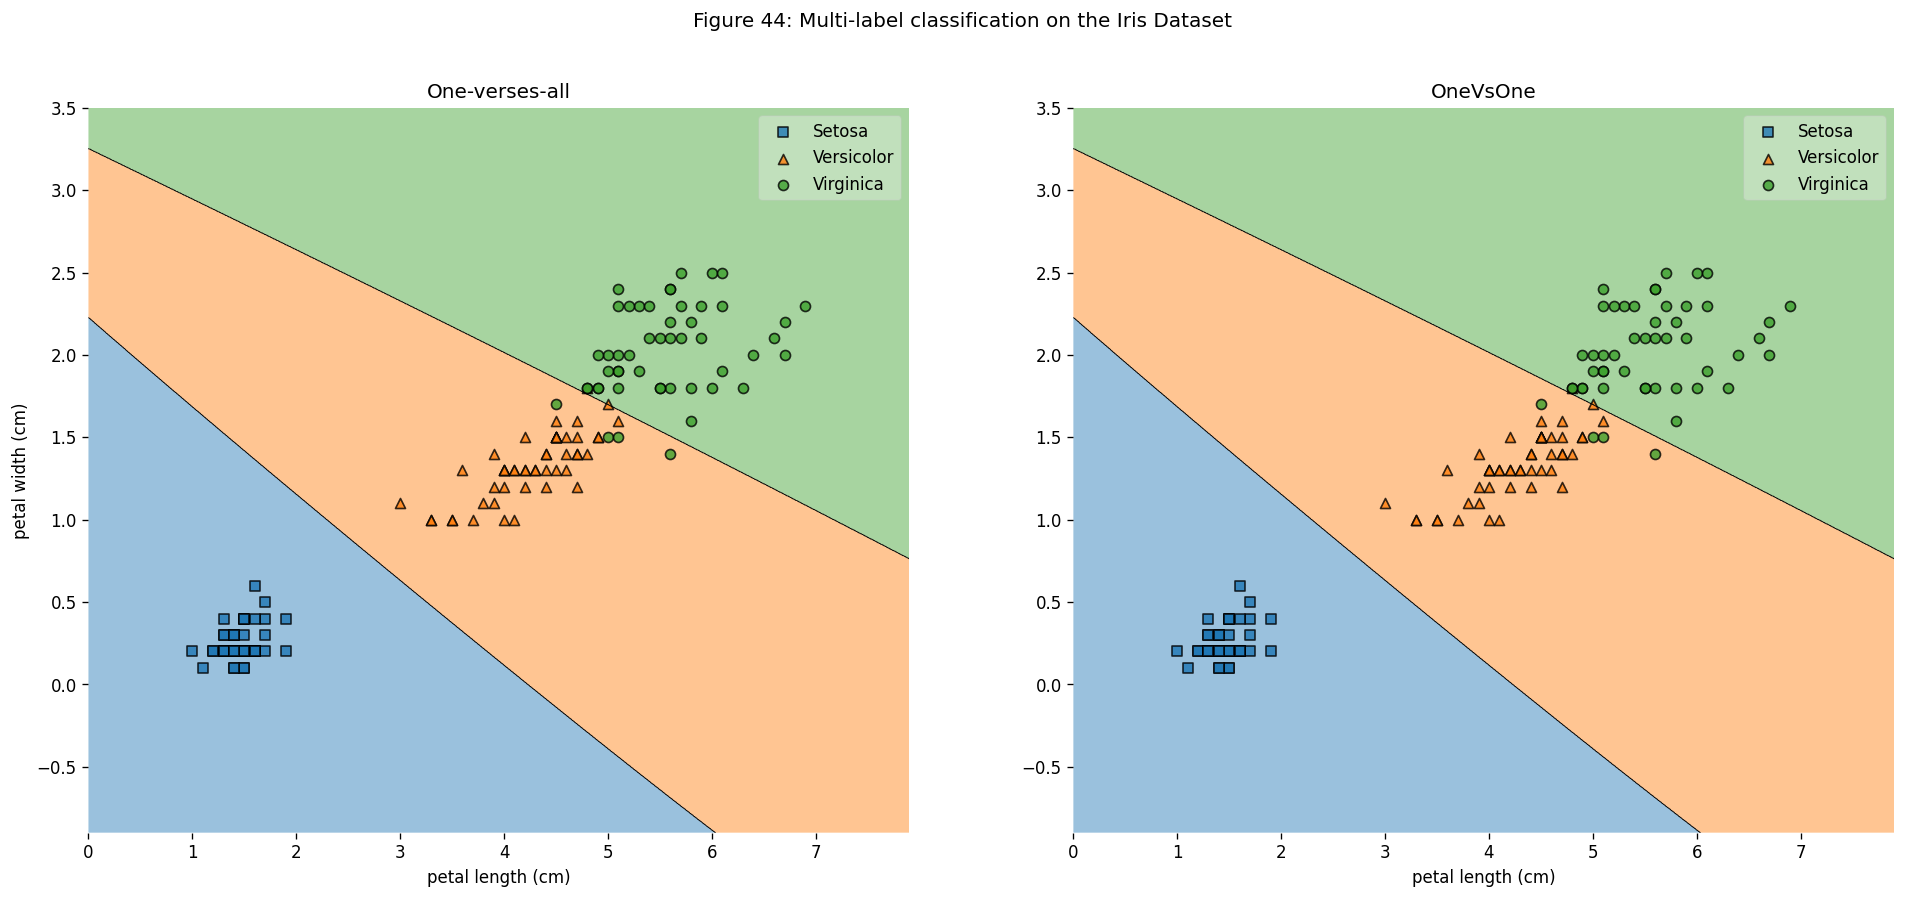

In [47]:
from mlxtend.plotting import plot_decision_regions

fig, axes = plt.subplots(ncols = 2, figsize=(width_inch*3, height_inch*2), sharey=True, sharex=True)

names = ["One-verses-all", "OneVsOne"]
for i, best_estimator in enumerate([ovr_rbf_rs.best_estimator_,ovo_rbf_rs.best_estimator_]):
    ax = axes[i]
    ax = plot_decision_regions(iris_df[features].values,
                               target.values,
                               clf = best_estimator,
                               ax = ax
                              )

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, target_names, 
              framealpha=0.3, scatterpoints=1)

    ax.set_title(names[i])

axes[0].set_xlabel(features[0])
axes[1].set_xlabel(features[0])
axes[0].set_ylabel(features[1])
fig_num+=1
plt.suptitle("Figure %d: Multi-label classification on the Iris Dataset"%fig_num)
plt.show()

### Multiclass scoring metrics$^9$

`scikit-learn` implements macro and micro averaging methods to extend scoring metrics to multiclass problems.

The _micro-average_ is calculated from each TPs, TNs, FPs, and FNs of the system. 

For example, the micro-average precision score for a $k$-class system is,

$$
PRE_{micro} = \frac{TP_1+\ldots+TP_K}{TP_1+\ldots+TP_K+FP_1+\ldots+FP_K}.
$$

This is useful when we want to weight each instance or prediction equally.

The _macro-average_ is the average scores of the different systems:

$$
PRE_{macro} = \frac{PRE_1+\ldots+PRE_K}{K}.
$$

This is useful when we want to evaluate the overall performance of a classifier with regard to the most frequent class labels.

# 8. Strengths and Limitations <a id='adv_lim'></a>

There are always advantages and disadvantages to using any model on a particular dataset. 

## Advantages

1. Kernels allow us to constuct hyperplanes in high dimensional spaces with tractable computation$^6$
    - SVMs allow for complex decision boundaries on both low-dimensional and high-dimensional data (i.e., few and many features).


2. SVMs always converge on the same answer given identical data and hyper-parameters.


3. Kernelized support vector machines perform well on a variety of datasets$^{16}$.


4. By softening the margin using a budget (or cost) parameter (C), SVMs are relatively robust to outliers$^{17}$.
    - Provided hyper-parameters are carefully selected, compared to some ML methods (e.g. Trees), SVM's are less likely to be effected by an over-representation of data in the training phase due to over-parameterization or over-fitting.

## Disadvantages

1. Non-linear SVM's do not scale very well with the number of samples.
    - However, there are batch algorithms which do improve this$^{11}$.
    

2. SVMs require careful preprocessing of the data and tuning of the parameters$^{16}$. 
    - Tree-based models require little or no pre‐processing. 

    
3. SVM models are hard to inspect$^{16}$. 
    - It can be difficult to understand why a particular prediction was made.
    - It might be tricky to explain the model to a nonexpert.


4. Discrete data typically presents a problem for SVMs. 
    - However, there are alternative implimentations in the litriture to handle discrete data$^{10}$.


5. They are comparatively sensitive to hyperparamters, there can be quite a variation in score depending on setup.
    - The choice of kernel for example can change the results considerably$^{15}$.


6. SVMs only produce predicted class labels (and their _"confidence"_).
    - Obtaining predicted class probabilities requires additional adjustments and computations not covered here.

# References
1. https://scikit-learn.org/stable/datasets/toy_dataset.html
2. Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn and Wes B Ford (1994) "The Population Biology of Abalone (_Haliotis_ species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait", Sea Fisheries Division, Technical Report No. 48 (ISSN 1034-3288)
3. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
4. Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.
5. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.
6. http://contrib.scikit-learn.org/imbalanced-learn/stable/introduction.html
7. https://beckernick.github.io/oversampling-modeling/
8. Mani, I., & Zhang, I. (2003, August). kNN approach to unbalanced data distributions: a case study involving information extraction. In Proceedings of workshop on learning from imbalanced datasets (Vol. 126).
9. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.
10. Lemaître, G., Nogueira, F., & Aridas, C. K. (2017). Imbalanced-learn: A python toolbox to tackle the curse of imbalanced datasets in machine learning. The Journal of Machine Learning Research, 18(1), 559-563.
11. Wilson, D. L. (1972). Asymptotic properties of nearest neighbor rules using edited data. IEEE Transactions on Systems, Man, and Cybernetics, (3), 408-421.
12. Tomek, I. (1976). Two modifications of CNN. IEEE Trans. Systems, Man and Cybernetics, 6, 769-772.
13. Batista, G. E., Prati, R. C., & Monard, M. C. (2004). A study of the behavior of several methods for balancing machine learning training data. ACM SIGKDD explorations newsletter, 6(1), 20-29.
14. https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html
15. Burges, C. J. (1998). A tutorial on support vector machines for pattern recognition. Data mining and knowledge discovery, 2(2), 121-167.
16. Müller, A. C., & Guido, S. (2016). Introduction to machine learning with Python: a guide for data scientists. " O'Reilly Media, Inc.".
17. https://bradleyboehmke.github.io/HOML/svm.html

In [44]:
# Create HTML notes document (preferred)
!jupyter nbconvert 3_Applications.ipynb \
    --to html \
    --output-dir . \
    --template classic
!jupyter nbconvert 3_Applications.ipynb \
    --to slides \
    --output-dir . \
    --TemplateExporter.exclude_input=True \
    --TemplateExporter.exclude_output_prompt=True \
    --SlidesExporter.reveal_scroll=True

[NbConvertApp] Converting notebook 3_Applications.ipynb to html
[NbConvertApp] Converting notebook 3_Applications.ipynb to slides
